In [1]:
# ==============================================================================
# NOTEBOOK 03: MODELAGEM PREDITIVA
# Objetivo: Treinar e avaliar um modelo para prever o rendimento da safra.
# ==============================================================================

# --- Importações de Bibliotecas ---
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import joblib

# Bibliotecas de Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# --- Configurações Globais ---
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)
warnings.filterwarnings('ignore')

# --- Carregamento dos Dados ---
# ATUALIZADO: Apontando para o dataset final com IBGE + Clima + NDVI
CAMINHO_DATASET_FINAL = '../data/processed/dataset_final_completo.csv' # <-- MUDANÇA AQUI
try:
    df_bruto = pd.read_csv(CAMINHO_DATASET_FINAL)
    print(f"Dataset final carregado com sucesso. Registos iniciais: {len(df_bruto)}")
    
    # ETAPA DE LIMPEZA FINAL: Remover todas as linhas que tenham qualquer valor em falta
    df = df_bruto.dropna()
    print(f"Registos com valores nulos (NaN) removidos. Registos restantes: {len(df)}")
    
    print("\nSetup concluído. DataFrame final e 100% limpo ('df') pronto para modelagem.")

except FileNotFoundError:
    print(f"ERRO: Arquivo final não encontrado em '{CAMINHO_DATASET_FINAL}'.")
    print("Por favor, execute o notebook 03_ETL_NDVI.ipynb primeiro.")

Dataset final carregado com sucesso. Registos iniciais: 3026
Registos com valores nulos (NaN) removidos. Registos restantes: 2522

Setup concluído. DataFrame final e 100% limpo ('df') pronto para modelagem.


In [2]:
# --- PREPARAÇÃO PARA MODELAGEM ---

# Definir as colunas que serão features (pistas)
# Esta lista será a final, incluindo a feature de NDVI
features = [
    'ano', 
    'latitude', 
    'longitude',
    'precipitacao_media_anual',
    'temp_max_media_anual',
    'temp_min_media_anual',
    'ndvi_max_safra' # A feature mais poderosa e importante!
]

# Definir a variável alvo
alvo = 'rendimento_medio_kg_ha'

# Separar X e y
X = df[features]
y = df[alvo]

# Dividir os dados em Conjunto de Treino e Conjunto de Teste (80/20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Dados separados em conjuntos de treino e teste!")
print(f"Dimensões de X_train: {X_train.shape}")
print(f"Dimensões de X_test: {X_test.shape}")

Dados separados em conjuntos de treino e teste!
Dimensões de X_train: (2017, 7)
Dimensões de X_test: (505, 7)


In [3]:
# --- MODELO BASELINE ---

print("Treinando o modelo RandomForest com parâmetros padrão...")
modelo_baseline = RandomForestRegressor(n_jobs=-1, random_state=42)
modelo_baseline.fit(X_train, y_train)

print("Avaliando o modelo baseline...")
y_pred_baseline = modelo_baseline.predict(X_test)
r2_baseline = r2_score(y_test, y_pred_baseline)
rmse_baseline = np.sqrt(mean_squared_error(y_test, y_pred_baseline))

print("\n--- Resultados da Avaliação do Modelo Baseline ---")
print(f"R² Score: {r2_baseline:.4f}")
print(f"RMSE: {rmse_baseline:.2f} kg/ha")

Treinando o modelo RandomForest com parâmetros padrão...
Avaliando o modelo baseline...

--- Resultados da Avaliação do Modelo Baseline ---
R² Score: 0.5498
RMSE: 972.35 kg/ha


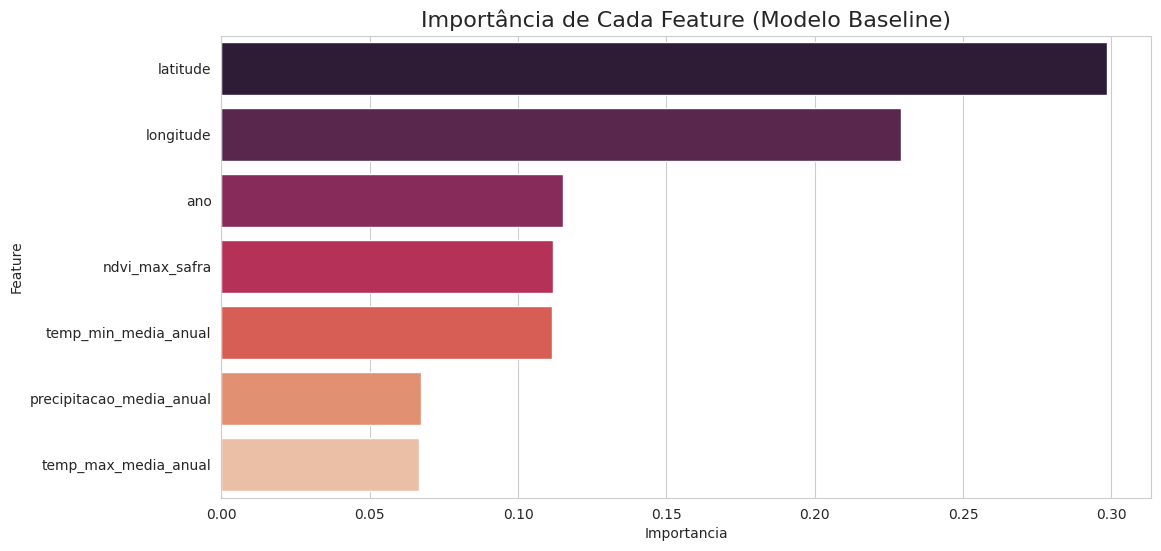

In [4]:
# --- ANÁLISE DO MODELO BASELINE: Importância das Features ---

importancias = modelo_baseline.feature_importances_
df_importancias = pd.DataFrame({
    'Feature': X_train.columns,
    'Importancia': importancias
}).sort_values(by='Importancia', ascending=False)

sns.barplot(x='Importancia', y='Feature', data=df_importancias, palette='rocket')
plt.title('Importância de Cada Feature (Modelo Baseline)', fontsize=16)
plt.show()

In [5]:
# --- CORREÇÃO DO VAZAMENTO E TREINAMENTO DO MODELO FINAL ---

print("Preparando dados para o modelo final (sem data leakage)...")

# 1. Definir as colunas FINAIS para as features
# Adicionamos a feature mais promissora: o NDVI
features_corrigidas = [
    'ano', 
    'latitude', 
    'longitude',
    'precipitacao_media_anual',
    'temp_max_media_anual',
    'temp_min_media_anual',
    'ndvi_max_safra'  # <-- ADIÇÃO IMPORTANTE
]

# 2. Separar X e y novamente com as features corretas
X_corrigido = df[features_corrigidas]
y_corrigido = df['rendimento_medio_kg_ha']

# 3. Dividir os dados em Treino e Teste novamente
X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(
    X_corrigido, y_corrigido, test_size=0.2, random_state=42
)

# 4. Instanciar e treinar o NOVO modelo
print("Iniciando o treinamento do novo modelo...")
modelo_rf_corrigido = RandomForestRegressor(n_jobs=-1, random_state=42)
modelo_rf_corrigido.fit(X_train_c, y_train_c)
print("Treinamento concluído!")

# 5. Fazer previsões e avaliar o novo modelo
print("\nAvaliando a performance do modelo corrigido...")
y_pred_c = modelo_rf_corrigido.predict(X_test_c)
r2_c = r2_score(y_test_c, y_pred_c)
rmse_c = np.sqrt(mean_squared_error(y_test_c, y_pred_c))

print("\n--- Resultados da Avaliação do Modelo CORRIGIDO ---")
print(f"R² Score: {r2_c:.4f}")
print(f"RMSE: {rmse_c:.2f} kg/ha")

Preparando dados para o modelo final (sem data leakage)...
Iniciando o treinamento do novo modelo...
Treinamento concluído!

Avaliando a performance do modelo corrigido...

--- Resultados da Avaliação do Modelo CORRIGIDO ---
R² Score: 0.5498
RMSE: 972.35 kg/ha


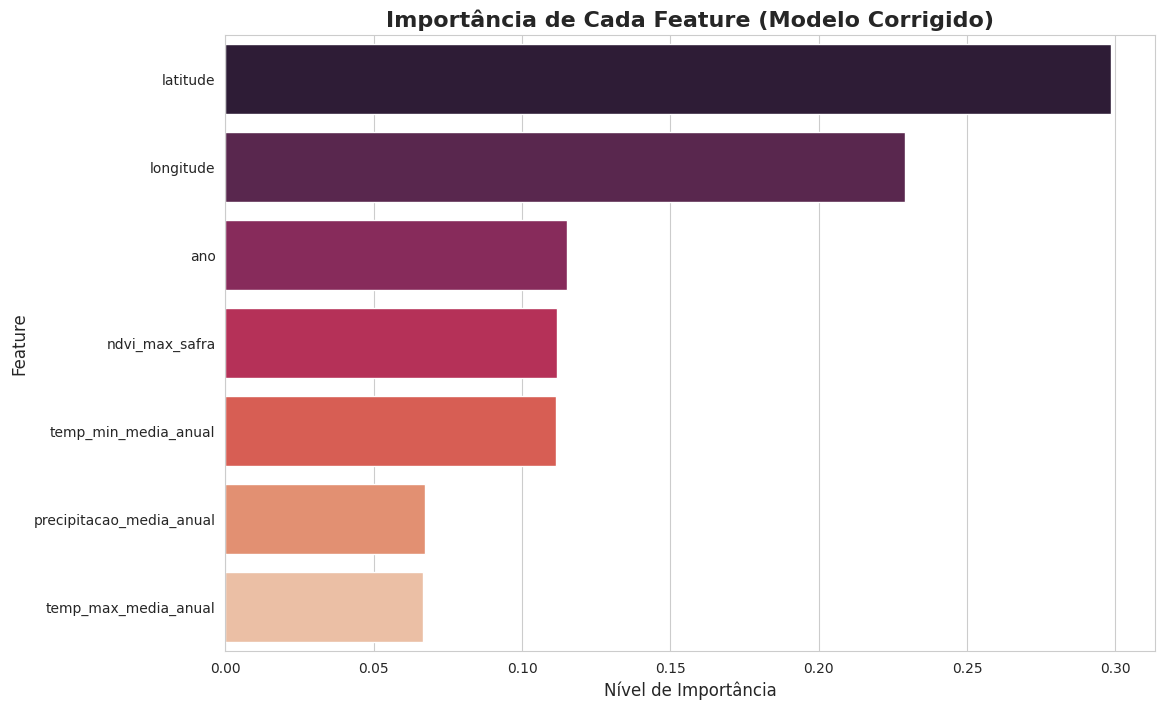

Ranking de Importância das Features (Modelo Corrigido):
                    Feature  Importancia
1                  latitude     0.298499
2                 longitude     0.228928
0                       ano     0.115223
6            ndvi_max_safra     0.111955
5      temp_min_media_anual     0.111398
3  precipitacao_media_anual     0.067229
4      temp_max_media_anual     0.066768


In [6]:
# --- ANÁLISE DO MODELO CORRIGIDO: Importância das Features ---

# Extrair a importância de cada feature do modelo CORRIGIDO
importancias_c = modelo_rf_corrigido.feature_importances_

# Criar um DataFrame para facilitar a visualização
df_importancias_c = pd.DataFrame({
    'Feature': X_train_c.columns, # Usando as colunas do X_corrigido
    'Importancia': importancias_c
}).sort_values(by='Importancia', ascending=False)

# Criar o gráfico de barras
plt.figure(figsize=(12, 8))
sns.barplot(x='Importancia', y='Feature', data=df_importancias_c, palette='rocket')

# Adicionar títulos e rótulos
plt.title('Importância de Cada Feature (Modelo Corrigido)', fontsize=16, weight='bold')
plt.xlabel('Nível de Importância', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.show()

# Exibir a tabela de importâncias
print("Ranking de Importância das Features (Modelo Corrigido):")
print(df_importancias_c)

In [7]:
# --- ENGENHARIA DE FEATURES E RETREINAMENTO ---

print("Iniciando a Engenharia de Features...")

# Criar uma cópia do nosso DataFrame para não alterar o original
df_features = df.copy()

# 1. Criar a nova feature: Precipitação Total Anual
# Assumindo 365.25 dias no ano para contar com anos bissextos
df_features['precipitacao_total_anual'] = df_features['precipitacao_media_anual'] * 365.25

print("Nova feature 'precipitacao_total_anual' criada.")

# 2. Definir a nova lista de features
features_com_nova_feature = [
    'ano', 
    'latitude', 
    'longitude',
    'precipitacao_media_anual', # Mantemos a média também
    'precipitacao_total_anual', # Nossa nova feature!
    'temp_max_media_anual',
    'temp_min_media_anual'
]

# 3. Separar X e y com a nova feature
X_novo = df_features[features_com_nova_feature]
y_novo = df_features['rendimento_medio_kg_ha']

# 4. Dividir em treino e teste
X_train_n, X_test_n, y_train_n, y_test_n = train_test_split(
    X_novo, y_novo, test_size=0.2, random_state=42
)

# 5. Treinar e avaliar o modelo com a nova feature
print("\nTreinando modelo com a nova feature...")
modelo_rf_novo = RandomForestRegressor(n_jobs=-1, random_state=42)
modelo_rf_novo.fit(X_train_n, y_train_n)
print("Treinamento concluído!")

y_pred_n = modelo_rf_novo.predict(X_test_n)
r2_n = r2_score(y_test_n, y_pred_n)
rmse_n = np.sqrt(mean_squared_error(y_test_n, y_pred_n))

print("\n--- Resultados da Avaliação do Modelo com Nova Feature ---")
print(f"R² Score Anterior: {r2_c:.4f}  |  Novo R² Score: {r2_n:.4f}")
print(f"RMSE Anterior: {rmse_c:.2f} kg/ha |  Novo RMSE: {rmse_n:.2f} kg/ha")

Iniciando a Engenharia de Features...
Nova feature 'precipitacao_total_anual' criada.

Treinando modelo com a nova feature...
Treinamento concluído!

--- Resultados da Avaliação do Modelo com Nova Feature ---
R² Score Anterior: 0.5498  |  Novo R² Score: 0.5612
RMSE Anterior: 972.35 kg/ha |  Novo RMSE: 960.01 kg/ha


In [8]:
from sklearn.model_selection import RandomizedSearchCV
from pprint import pprint # Para imprimir o dicionário de forma bonita

# --- AJUSTE DE HIPERPARÂMETROS ---

print("Iniciando a busca pelos melhores hiperparâmetros...")

# 1. Definir o "espaço de busca": quais configurações testar e com quais valores.
# Criamos um dicionário onde as chaves são os nomes dos parâmetros do RandomForest
param_grid = {
    'n_estimators': [100, 200, 300, 500, 700],      # Número de árvores na floresta
    'max_features': ['sqrt', 'log2'],               # Número de features a considerar em cada split
    'max_depth': [10, 20, 30, None],               # Profundidade máxima de cada árvore
    'min_samples_split': [2, 5, 10],               # Mínimo de amostras para dividir um nó
    'min_samples_leaf': [1, 2, 4],                 # Mínimo de amostras em um nó folha
    'bootstrap': [True]                            # Se as amostras são com ou sem reposição
}

# 2. Instanciar o RandomizedSearchCV
# Ele fará 50 tentativas aleatórias (n_iter=50)
# Usará 3-fold cross-validation (cv=3)
random_search = RandomizedSearchCV(estimator=modelo_rf_corrigido, 
                                   param_distributions=param_grid, 
                                   n_iter=50, 
                                   cv=3, 
                                   verbose=2, 
                                   random_state=42, 
                                   n_jobs=-1)

# 3. Executar a busca com os dados de TREINO (usamos o X e y corrigidos)
random_search.fit(X_train_c, y_train_c)

# 4. Exibir os melhores parâmetros encontrados
print("\nMelhores parâmetros encontrados:")
pprint(random_search.best_params_)

# 5. Avaliar o MELHOR modelo encontrado pela busca
best_model = random_search.best_estimator_
y_pred_best = best_model.predict(X_test_c)
r2_best = r2_score(y_test_c, y_pred_best)
rmse_best = np.sqrt(mean_squared_error(y_test_c, y_pred_best))

print("\n--- Resultados da Avaliação do Modelo OTIMIZADO ---")
print(f"R² Score Anterior: {r2_c:.4f}  |  Novo R² Score (Otimizado): {r2_best:.4f}")
print(f"RMSE Anterior: {rmse_c:.2f} kg/ha |  Novo RMSE (Otimizado): {rmse_best:.2f} kg/ha")

Iniciando a busca pelos melhores hiperparâmetros...
Fitting 3 folds for each of 50 candidates, totalling 150 fits
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   0.4s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   0.4s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   0.4s
[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=300; total time=   0.9s
[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=300; total time=   1.0s
[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=300; total time=   1.1s
[CV] END bootstrap=True, max_depth=10, max_features=log2, min

In [9]:
# --- FINALIZAÇÃO: Salvando o Modelo Treinado ---

# Criar a pasta 'models' se ela não existir
import os
os.makedirs('../models', exist_ok=True)

# Definir o caminho para salvar o modelo
caminho_modelo = '../models/agrovision_random_forest_v1.joblib'

# Salvar o objeto do modelo em um arquivo usando joblib
joblib.dump(modelo_rf_corrigido, caminho_modelo)

print(f"Modelo final salvo com sucesso em: {caminho_modelo}")\
    

Modelo final salvo com sucesso em: ../models/agrovision_random_forest_v1.joblib
